# Example of running docking and scoring of ensitrelvir affinities in coronavirus targets

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load OpenEye license, required by the asapdiscovery package
!export OE_LICENSE=$HOME/Documents/.openeye/oe_license.txt

For this example, we will use a reference SARS-CoV-2 crystal in complex with ensitrelvir. The ligand will be docked into related coronavirus targets that infect humans. 

In [2]:
ref_pdb = "input_files/8dz0.pdb"

## 1. Sequence alignment

In this example, we perform a sequence-based search starting from a pdb file of SARS-CoV-2 in complex with Ensitrelvir (8dz0). This is done with `asap-spectrum seq-alignment` (See [documentation](https://asapdiscovery.readthedocs.io/en/latest/index.html) for instructions on how to use).

The sequence search is done by invoking the NCBI BLAST server over the internet, and it will take longer everytime a job is placed for a given sequence. Therefore, we advise to run the sequence alignment job only once and save the BLAST output as a .xml file for future runs. Below we provide the command for an initial sequence alignment job, starting from a pdb file (uncomment to use).

An email address is required the Entrez database system, which is used for retrieving information on viral hosts (for the filtering step of the alignment process). 

In [ ]:
#!asap-spectrum seq-alignment \
#        -f {ref_pdb} \
#        -t "pdb" \
#        --output-dir "data/sars2_alignment" \
#        --sel-key "host: Homo sapiens OR organism: human" \
#        --multimer --n-chains 2 \
#        --color-seq-match --plot-width 900 \
#        --max-mismatches 2 \
#        --email "your_email.org" # !! Replace with your email that will be used for Entrez (viral host search)

By default, the results from the BLAST search above are saved as `results.xml`. We provide this file in the `data/` directory. **After replacing the email argument**, the run below will generate the necessary files for the rest of the pipeline, along with a html visualization of the alignment. 

In [ ]:
!asap-spectrum seq-alignment \
        -f "input_files/results.xml" \
        -t "pre-calc" \
        --output-dir "data/sars2_alignment" \
        --sel-key "host: Homo sapiens OR organism: human" \
        --multimer --n-chains 2 \
        --color-seq-match --plot-width 900 \
        --max-mismatches 2 \
        --email "your_email.org" # !! Replace with your email that will be used for Entrez (viral host search)

## 2. ColabFold run to generate AlphaFold2 predicted models

The next step is folding the filtered sequences using the AlphaFold2 multimer model. This step requires a local installation of ColabFold so we provide an script to generate the data on the `data/` directory.

The script should look as follows:

```bash
#!/bin/bash
ref_pdb="input_files/8dz0.pdb"
csv_fn="data/sars2_alignment/SARS-CoV-2-Mpro.csv"
template_dir="data/template_dir_apo"
out_dir="data/sars2_alignment/cf_results_human_CoV/"

mkdir $template_dir
cp $ref_pdb $template_dir/0001.pdb

module load colabfold/v1.5.2

colabfold_batch $csv_fn $out_dir  \
 --num-recycle 3 --num-models 3 --model-type "alphafold2_multimer_v3" \
 --templates --custom-template-path $template_dir \
```


## 2.1. Structure alignment of ColabFold results

The next step is to extract the structures from the ColabFold run and align them to the reference target. The `asap-spectrum struct-alignment` module takes cares of this (see [documentation](https://asapdiscovery.readthedocs.io/en/latest/index.html) for instructions.)

The command below generates a folder with the aligned ligand-less structures `aligned_structures/`.

In [16]:
!asap-spectrum struct-alignment \
        -f "data/sars2_alignment/SARS-CoV-2-Mpro.csv" \
        --pdb-file {ref_pdb} \
        --output-dir "data/sars2_alignment/aligned_structures/" \
        --cfold-results "data/sars2_alignment/cf_results_human_CoV"\
        --color-by-rmsd \
        --cf-format "alphafold2_multimer_v3" \

RMSD for seed 000 is 2.5291640282355132 A
YP_009725295_1 seed with least RMSD is 000 with RMSD 2.5291640282355132 A
RMSD for seed 000 is 2.7313637564401962 A
YP_009944365_1 seed with least RMSD is 000 with RMSD 2.7313637564401962 A
RMSD for seed 000 is 2.4801465873017134 A
YP_009047217_1 seed with least RMSD is 000 with RMSD 2.4801465873017134 A
RMSD for seed 000 is 2.3460594696310992 A
YP_009944273_1 seed with least RMSD is 000 with RMSD 2.3460594696310992 A
RMSD for seed 000 is 1.9467582184025503 A
YP_009555250_1 seed with least RMSD is 000 with RMSD 1.9467582184025503 A
RMSD for seed 000 is 1.8402437616490752 A
NP_835346_1 seed with least RMSD is 000 with RMSD 1.8402437616490752 A
RMSD for seed 000 is 2.0171923267210268 A
YP_010229075_1 seed with least RMSD is 000 with RMSD 2.0171923267210268 A


## 3. Ligand transfer docking

The next step is to dock the ligand from the reference into the apo proteins. This is done by the `ligand-transfer-docking` command from `asapiscovery`. It takes the folder with aligned structures that we obtained in the previous step as an input, an will return the best pose of each target with the ligans in the reference protein, as well as a summary of the results in a csv file `docking_results_final.csv`. Refer to the `asapdiscovery` documentation for more information.

It is advisable to prepare the proteins before running the docking to cap the termini and fill-in missing side chains. We provided a folder with 4 of the proteins from the previous step, prepared using Maestro. The command below will take a while to run. 

In [27]:
docking_results_dir = "data/transfer_docking_ensitrelvir"
docked_prep = "input_files/aligned_structures_p/"

In [ ]:
!asap-docking ligand-transfer-docking \
        --target SARS-CoV-2-Mpro \
        --structure-dir {docked_prep} \
        --ref-pdb-file {ref_pdb} \
        --output-dir {docking_results_dir} \
        --allow-retries --use-omega --omega-dense --allow-final-clash \
        --posit-confidence-cutoff 0.0 \

## 4. MD refinement & Scoring of pose predictions 
Next, we refined the docking poses and score them. This is done by the `score_complexes.py` script included in the `scripts/` folder. The script takes a folder with the posed complexes as input, as well as the reference complex pdb.

From the `ligand-transfer-docking` run above, we need the pdbs of the poses and the results file. We extract the pdb file into a directory `data/docked_ensitrelvir/`, using a bash script (provided in `scripts/`), and then we run the scoring.

In [ ]:
# Extract pdbs from ligand-ransfer-docking directory
protein_regex = "'YP_[0-9]+_[0-9]+|NP_[0-9]+_[0-9]+'" # pattern that matches the name of the targets
docked_dir = "data/docked_ensitrelvir/"

!bash "scripts/copy_posed_pdbs.sh" {docking_results_dir} {docked_dir} {protein_regex}


In this example run, we will minimize the pdbs to refine the docked poses first, and then we wil do the scoring. The script below will generate a ChemGauss4 score, ML scores (SchNet, E3NN and GAT), Ligand RMSD and AutoDock Vina score. To generate gnina scores the `--gnina-score` command can be used, along with a script to run gnina via  `--gnina-script` and a directory to save the intermediate files in `--home-dir`. A couple of example gnina scripts are provided in `scripts/`, but a working insatallation of gnina is needed. 

In [ ]:
!python3.10 "scripts/score_complexes.py" \
        -f {ref_pdb} \
        -d {docked_dir} \
        -o "data/ensitrelvir_scores.csv" \
        --docking-csv {docking_results_dir}/data_intermediates/docking_scores_filtered_sorted.csv \
        --comp-name SARS --target-name SARS-CoV-2-Mpro \
        --protein-regex {protein_regex} \
        --minimize \
        --vina-score --ml-score \
        --path-to-grid-prep "scripts/" \
        --chain-dock "A" --chain-ref "A" \
        --log-level debug \

# Plotting the results
Now we will plot the scores generated in the previous step. We have included a csv file with all the scores, including those using AutoDock Vina and Gnina in the `data/` directory for reference, and we will use those for the plotting. We also added a column for `'blast-descriptor'` and `'blast-score'` using the data from `blast.csv` produced in the sequence alignment step. 

In [3]:
# Import all the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.plot_results import plot_bar_scores_in_df, plot_score_correlation, scatter_scores, get_roc_curve, get_conf_mat


We import the csv as a pandas DataFrame

In [4]:
df_scores = pd.read_csv("data/ensitrelvir_scores.csv")
print(df_scores.head())

          prot-ID  gnina-RMSD  gnina-dock-Affinity  gnina-Affinity-var  \
0     NP_835346_1      0.3683              -9.8820             -0.9099   
1  YP_001718611_1      0.5179              -8.9478             -0.9146   
2  YP_002308478_1      0.6986              -9.3604             -0.6978   
3  YP_005352862_1      0.8092              -9.2297             -1.0152   
4  YP_008439216_1      0.5097             -10.6673             -0.9464   

   CNN_dock_score  CNN_dock_affinity  premin-score-POSIT  docking-score-POSIT  \
0          0.3786             7.0892           -2.265110           -10.109201   
1          0.3047             7.0430           -4.637259           -11.285685   
2          0.0875             6.5198            8.447901            -8.899652   
3          0.3832             6.9464            8.869884            -7.681045   
4          0.7628             7.8320           -6.364501           -11.328412   

   computed-SchNet-pIC50  computed-E3NN-pIC50  computed-GAT-pIC50  L

The experimental signal is provided in the `data/` directory as a `csv` file. This data corresponds to the recovery signal compared to a DMSO background, from a cellular assay of ensitrelvir on a coronavirus panel (from this [reference paper](https://journals.asm.org/doi/full/10.1128/jvi.00597-23)). We convert the signal by substracting it to the DMSO reference of 100, such that it is proportional to the strength of ensitrelvir against each target, and add a second column labeling whether the ligand is *active*, *partial* or *inactive* against the target.

In [5]:
df_signal = pd.read_csv("data/sars_ensit_signal.csv")

df_all = df_scores.merge(df_signal[['prot-ID','signal']], how = 'inner', on = ['prot-ID'])
df_all['signal'] = df_all['signal'].apply(lambda x: 100-x)
df_all["Activity"] = df_all["signal"].apply(lambda x: "active" if x > 50 else "partial" if x > 30 else "inactive")
df_all.reset_index(drop=True, inplace=True)
print(df_all[['prot-ID', 'signal', 'Activity']])

           prot-ID  signal  Activity
0      NP_835346_1      10  inactive
1   YP_001718611_1       0  inactive
2   YP_002308478_1       4  inactive
3   YP_005352862_1       1  inactive
4   YP_008439216_1       0  inactive
5   YP_009047217_1      82    active
6   YP_009336483_1       0  inactive
7   YP_009513020_1       0  inactive
8   YP_009555250_1       0  inactive
9   YP_009725295_1     100    active
10  YP_009924387_1       0  inactive
11  YP_009944273_1      33   partial
12  YP_009944365_1      88    active
13  YP_010037473_1       0  inactive
14  YP_010037559_1      10  inactive
15  YP_010229075_1      10  inactive


Read fingerprint score data

In [6]:
plif_scores = pd.read_csv("data/fingerprint_scores.csv", index_col=0)
plif_scores['Structure'] = plif_scores['Structure'].str.extract(r'^(YP_\d+_\d+|NP_\d+_\d+)')
plif_scores = plif_scores.rename(columns={'Structure':'prot-ID'})
plif_all = plif_scores.pivot(index="prot-ID", columns="provenance", values="tversky_index").reset_index()
plif_all.drop(columns=['ByEverything', 'ByInteractionType'], inplace=True)
df_wfingerprint = df_all.merge(plif_all, how = 'inner', on = ['prot-ID'])

Calculate binding site similarity

In [7]:
from scripts.structure_compare import calculate_bsite_score
from Bio import AlignIO
sars2_alignment = "input_files/sars2_alignment/SARS-CoV-2-Mpro_alignment.fasta"
alignment = AlignIO.read(sars2_alignment, "fasta")
pdb_dir = "input_files/docked_minimized_ensitrelvir_all/"
ref_pdb = "input_files/8dz0_min.pdb"
prot_id, seq_score = calculate_bsite_score(alignment, ref_pdb, pdb_dir, ref_idx=0, 
                                           chain_mob='1', chain_ref='1', lig_mob='UNK', lig_ref='UNK',)
df = pd.DataFrame({'prot-ID': prot_id, 'Bsite-seq-identity': np.round(seq_score,2)})
df_all = df_wfingerprint.merge(df, how = 'inner', on = ['prot-ID'])

PDB wasn't found for label YP_001876436_1


First, we will plot all of the relevant scores calculated in a bar plot, with the scores re-scaled from 0 to 1.

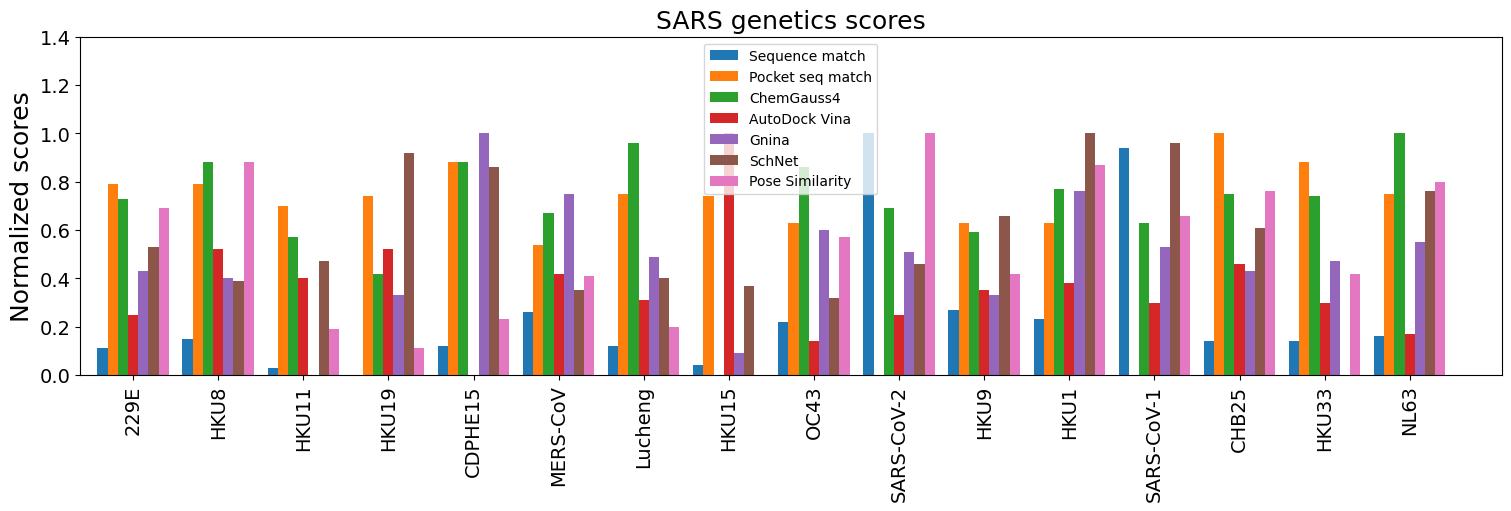

In [ ]:
col_labels = ['blast-scores', 
              'Bsite-seq-identity',
              'docking-score-POSIT', 
              'Vina-score-min', 
              'CNN_dock_affinity',
              'computed-SchNet-pIC50',
              'Pose Similarity',
              'ByTotalInteractions',
              'ByInteractionTypeAndResidueType',
              'signal', 
              ]
score_labels = ['Sequence match',
                'Pocket seq match',
                'ChemGauss4', 
                'AutoDock Vina', 
                'Gnina', 
                'SchNet', 
                'Pose Similarity',
                'Fingerprint total',
                'Fingerprint by int and res type',
                'Signal Inhibition',]
sign_list = [1,-1,-1,1,1,1,1]
df_all['Lig-RMSD'] = df_all['Lig-RMSD'].replace(-1, 10)
df_all['Pose Similarity'] = 1/(1+df_all['Lig-RMSD'])
fig = plot_bar_scores_in_df(df_all, target_labels=df_all['blast-descriptor'], 
                            label_cols=col_labels, sign_list=sign_list, 
                            score_labels=score_labels,
                            title='SARS genetics scores', yrange=[0, 1.4], 
                            ylabel='Normalized scores', figsize=(15,5.), label_bars=False, bar_width=0.12)

It is important to observe the correlation between different scores, especially, with respect to the experimental *Signal Inhibition*. We compare the correlation of each score with the experimental signal on a bar plot.

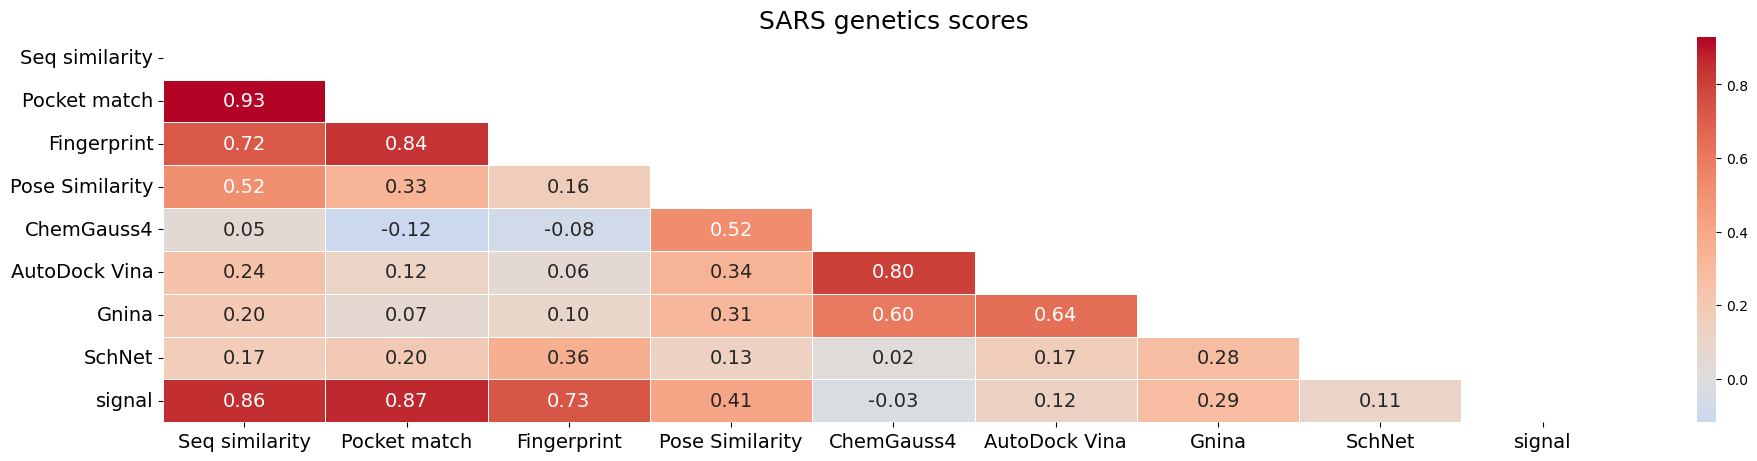

In [9]:
df = df_all.copy()
df = df[['blast-scores', 'Bsite-seq-identity', 'ByInteractionTypeAndResidueType', 'Pose Similarity', 'docking-score-POSIT', 'Vina-score-min', 'CNN_dock_affinity', 'computed-SchNet-pIC50', 'signal']]
df['docking-score-POSIT'] = df['docking-score-POSIT'].apply(lambda x: -x)
df['Vina-score-min'] = df['Vina-score-min'].apply(lambda x: -x)
df = df.rename(columns={'blast-scores': 'Seq similarity', 'Bsite-seq-identity': 'Pocket match', 'ByInteractionTypeAndResidueType': 'Fingerprint', 'docking-score-POSIT': 'ChemGauss4', 'Vina-score-min': 'AutoDock Vina', 'CNN_dock_affinity': 'Gnina', 'computed-SchNet-pIC50': 'SchNet'})
fig = plot_score_correlation(df, 'blast-descriptor', 'signal', 'SARS genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(17.5,4.5), type='heatmap')

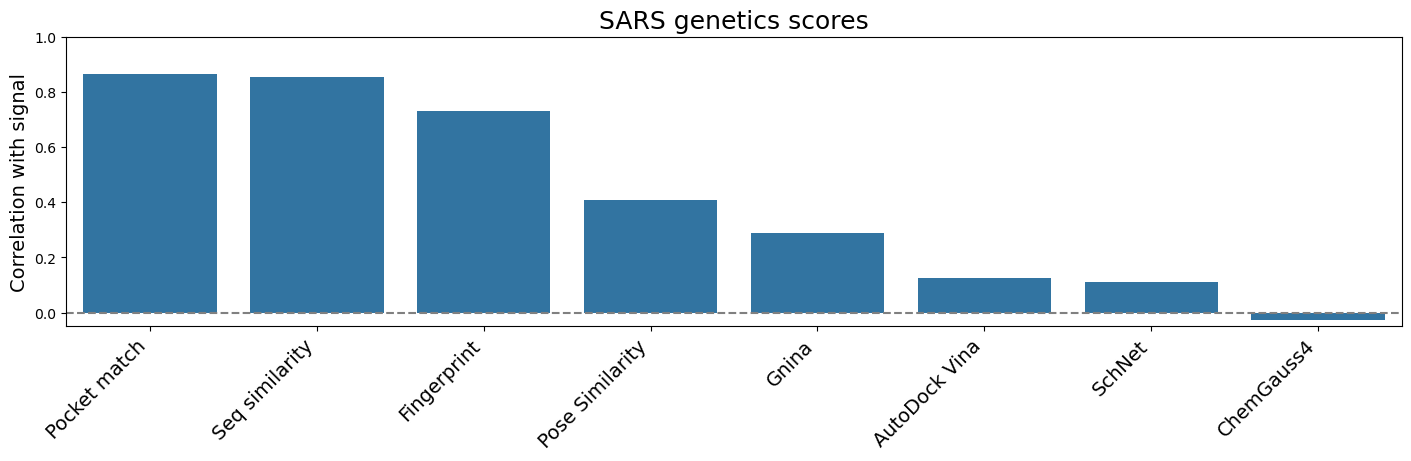

In [10]:
fig = plot_score_correlation(df, 'blast-descriptor', 'signal', 'SARS genetics scores', [-0.05, 1.05], 'Signal Inhibition', 'Normalized scores',
                  figsize=(14,4.5), type='bars')

Below, a scatter plot shows the correlation between the experimental signal and three different scores: The *AutoDock Vina* and *Gnina* scores and the sequence similarity (*BLAST score*). The points are colored by activity (**red**=Active, **red**=Partial, **blue**=Inactive).

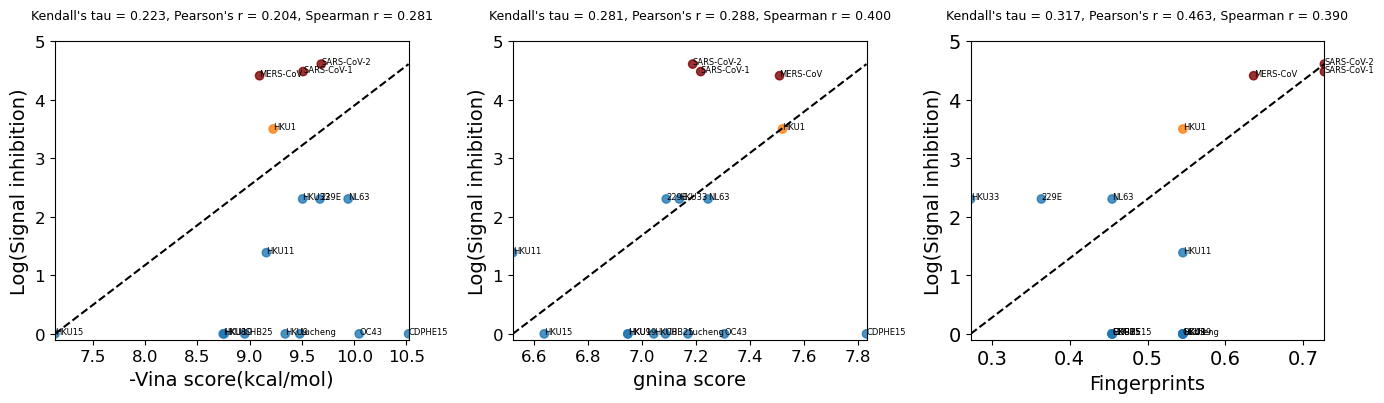

In [17]:
signal = np.log(df_all['signal'])
signal[signal == -np.inf] = 0

fig, axs = plt.subplots(1, 3, figsize=(14,4.2))

ax1 = scatter_scores(axs[0], -df_all['Vina-score-min'], signal,
                    '-Vina score(kcal/mol)', 'Log(Signal inhibition)',title='',
                    ylim=(-0.1, 5), point_labels=df_all["blast-descriptor"],  hue=df_all['Activity'],)
ax2 = scatter_scores(axs[1], df_all['CNN_dock_affinity'], signal,
                    'gnina score', 'Log(Signal inhibition)', title='',
                    ylim=(-0.1, 5), point_labels=df_all["blast-descriptor"], hue=df_all['Activity'],)
ax3 = scatter_scores(axs[2], df_all['ByInteractionTypeAndResidueType'], signal,
                    'Fingerprints', 'Log(Signal inhibition)', title='',
                    ylim=(-0.1, 5), point_labels=df_all["blast-descriptor"], hue=df_all['Activity'],)
plt.tight_layout()

We can also plot the confusion matrix for different scores, to visualize how accurate or scores can classify ligand activity across the different coronaviruses. The classification is done by setting an inhibition criteria that includes both *Partial* and *Active* categories (top row) and only *Active* (bottom row).

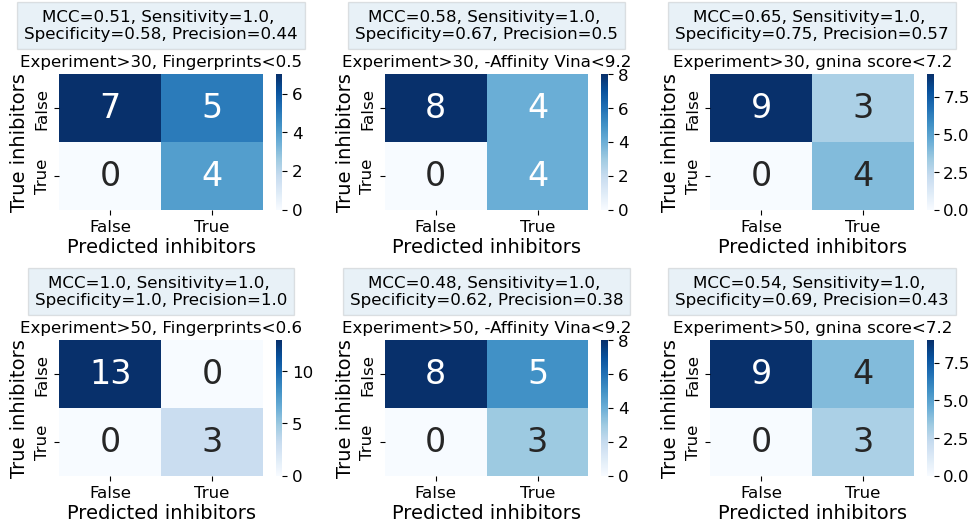

In [ ]:
true_actives = df_all[df_all['Activity'] == 'active']
true_actives_ext = df_all[df_all['Activity'].isin(['active','partial'])]

fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
ax1 = get_conf_mat(axs[0, 0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'], min(true_actives_ext['ByInteractionTypeAndResidueType']), 30, 'Fingerprints')
ax2 = get_conf_mat(axs[1, 0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'], min(true_actives['ByInteractionTypeAndResidueType']), 50, 'Fingerprints')

ax1 = get_conf_mat(axs[0, 1], -df_all['Vina-score-premin'], df_all['signal'], min(-true_actives_ext['Vina-score-premin']), 30, '-Affinity Vina')
ax2 = get_conf_mat(axs[1, 1], -df_all['Vina-score-premin'], df_all['signal'], min(-true_actives['Vina-score-premin']), 50, '-Affinity Vina')

ax1 = get_conf_mat(axs[0, 2], df_all['CNN_dock_affinity'], df_all['signal'], min(true_actives_ext['CNN_dock_affinity']), 30, 'gnina score')
ax2 = get_conf_mat(axs[1, 2], df_all['CNN_dock_affinity'], df_all['signal'], min(true_actives['CNN_dock_affinity']), 50, 'gnina score')

fig.subplots_adjust(hspace=1)
fig.tight_layout()


Finally, the most useful metric for a scoring approach at an early stage of the durg discovery pipeline, is the ROC curve, which can indicate to potential of our model to rank molecules. The AUC score is calculated through a bootstrap sampling, which allows is to calculate the uncertainty of the measure.

AUC is 0.95, with bootstrap-sampling is 0.95+/-0.005
95% Confidence Interval: [0.85, 1.00]
AUC is 1.0, with bootstrap-sampling is 1.0+/-0.0
95% Confidence Interval: [1.00, 1.00]
AUC is 0.75, with bootstrap-sampling is 0.75+/-0.013
95% Confidence Interval: [0.47, 1.00]
AUC is 0.67, with bootstrap-sampling is 0.66+/-0.015
95% Confidence Interval: [0.38, 0.92]
AUC is 0.83, with bootstrap-sampling is 0.84+/-0.011
95% Confidence Interval: [0.58, 1.00]
AUC is 0.74, with bootstrap-sampling is 0.74+/-0.015
95% Confidence Interval: [0.46, 0.98]


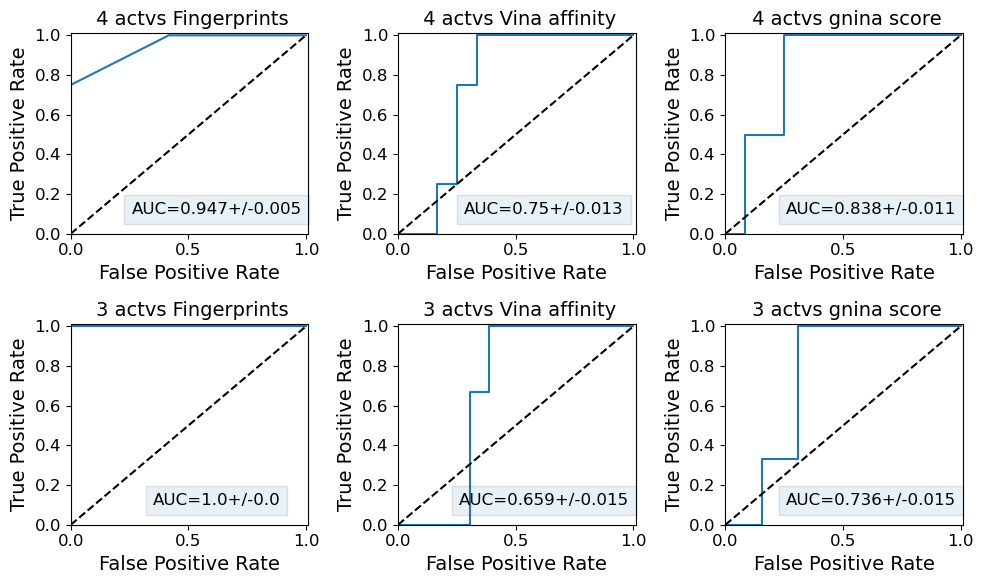

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

title = lambda x: f" {np.count_nonzero(df_all['signal']>x)} actvs"

ax1 = get_roc_curve(axs[0,0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'] > 30, pred_type='Fingerprints', title=title(30), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,0], df_all['ByInteractionTypeAndResidueType'], df_all['signal'] > 50, pred_type='Fingerprints', title=title(50), n_bootstraps=100)

ax1 = get_roc_curve(axs[0,1], -df_all['Vina-score-premin'], df_all['signal'] > 30, pred_type='Vina affinity', title=title(30), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,1], -df_all['Vina-score-premin'], df_all['signal'] > 50, pred_type='Vina affinity', title=title(50), n_bootstraps=100)

ax1 = get_roc_curve(axs[0,2], df_all['CNN_dock_affinity'].fillna(0), df_all['signal'] > 30,  pred_type='gnina score', title=title(30), n_bootstraps=100)
ax2 = get_roc_curve(axs[1,2], df_all['CNN_dock_affinity'].fillna(0), df_all['signal'] > 50,  pred_type='gnina score', title=title(50), n_bootstraps=100)

plt.tight_layout()

We can also visualize different scores in the same plot to compare their performance,